In [1]:
!pip install audiomentations

INFO: pip is looking at multiple versions of numpy-minmax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpy-rms to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 7.1 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Shift, ClippingDistortion, PolarityInversion, Gain
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2025-04-15 15:18:13.918089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744730294.090878      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744730294.141795      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Paths
DATA_PATH = '/kaggle/input/urbansound8k/'
METADATA_PATH = '/kaggle/input/urbansound8k/UrbanSound8K.csv'

# Metadata loading
metadata = pd.read_csv(METADATA_PATH)


In [4]:
metadata.head(3)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing


In [5]:
metadata.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [6]:
def find_file(file_name, base_dir='/kaggle/input/urbansound8k/'):
    for folder in range(1, 11):
        file_path = os.path.join(base_dir, f"fold{folder}", file_name)
        if os.path.exists(file_path):
            return file_path
    return None

In [7]:
samples_to_consider = 22050 * 4

In [8]:
def extract_features(file_path, fixed_length=168, augment=False):
    augmenter = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.02, p=0.5),
        PitchShift(min_semitones=-6, max_semitones=6, p=0.5),
        TimeStretch(min_rate=0.8, max_rate=1.2, p=0.4),
        Shift(min_shift=-0.7, max_shift=0.7, shift_unit='fraction', p=0.5),
        ClippingDistortion(p=0.3),
        PolarityInversion(p=0.3),
        Gain(min_gain_db=-6.0, max_gain_db=6.0, p=0.3),
    ])
    try:
        audio, sr = librosa.load(file_path, sr=22050, mono=True)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=min(2048, len(audio)), n_mels=168, fmax=8000, hop_length=512)
        mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        if augment and np.random.rand() < 0.5:
            num_freqs, num_frames = mel_db.shape
            f = np.random.randint(0, min(10, num_freqs))
            f0 = np.random.randint(0, num_freqs - f)
            mel_db[f0:f0 + f, :] = 0

            t = np.random.randint(0, min(20, num_frames))
            t0 = np.random.randint(0, num_frames - t)
            mel_db[:, t0:t0 + t] = 0

            audio = augmenter(samples=audio, sample_rate=sr)

        if mel_db.shape[1] > fixed_length:
            mel_db = mel_db[:, :fixed_length]
        else:
            mel_db = np.pad(mel_db, ((0, 0), (0, fixed_length - mel_db.shape[1])), mode='constant')
        return mel_db
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None


In [9]:
X, y = [], []
for index, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = find_file(row['slice_file_name'], DATA_PATH)
    if os.path.exists(file_path):
        features = extract_features(file_path, augment=np.random.rand() < 0.5)
        if features is not None:
            X.append(features)
            y.append(row['classID'])

100%|██████████| 8732/8732 [08:04<00:00, 18.03it/s]


In [10]:
# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)  # Shape: (8732, 168, 168)
y = np.array(y)

# **Expand dimensions correctly**
X = np.expand_dims(X, axis=-1)  # Shape: (8732, 168, 168, 1)

# ✅ Final Check
print("✅ Final Feature Shape:", X.shape)  # Expected: (8732, 168, 168, 1)
print("✅ Labels Shape:", y.shape)   # Expected: (8732,)


✅ Final Feature Shape: (8732, 168, 168, 1)
✅ Labels Shape: (8732,)


In [11]:
# Normalize
X = (X - np.mean(X)) / np.std(X)

# One-hot encoding
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes=num_classes)

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [13]:
# Check final shape
print(f"✅ y_train shape after encoding: {y_train.shape}")  # Expected: (6985, 10)
print(f"✅ y_test shape after encoding: {y_test.shape}")  # Expected: (1747, 10)

✅ y_train shape after encoding: (6112, 10)
✅ y_test shape after encoding: (2620, 10)


In [14]:
# CNN + Residual Connections
inputs = layers.Input(shape=(168, 168, 1))

def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='gelu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('gelu')(x)
    return x

x = layers.Conv2D(32, (3, 3), activation='gelu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 32)
x = layers.SpatialDropout2D(0.3)(x)

x = layers.Conv2D(64, (3, 3), activation='gelu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)
x = layers.SpatialDropout2D(0.3)(x)

x = layers.Conv2D(128, (3, 3), activation='gelu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 128)
x = layers.SpatialDropout2D(0.3)(x)

x = layers.Conv2D(256, (3, 3), activation='gelu', padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 256)
x = layers.SpatialDropout2D(0.3)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Reshape((1, 256))(x)

2025-04-15 15:26:34.795611: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
# Transformer Block
attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=256)(x, x)
x = layers.Add()([x, attn_output])
x = layers.LayerNormalization()(x)
ffn_output = layers.Dense(256, activation='gelu')(x)
x = layers.Add()([x, ffn_output])
x = layers.LayerNormalization()(x)

In [16]:
# Attention after LSTM
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
attention = layers.Dense(1, activation='tanh')(x)
attention = layers.Flatten()(attention)
attention_weights = layers.Activation('softmax')(attention)
attention_weights = layers.RepeatVector(1024)(attention_weights)
attention_weights = layers.Permute([2, 1])(attention_weights)
attended = layers.multiply([x, attention_weights])
attended = layers.Lambda(lambda xin: tf.reduce_sum(xin, axis=1))(attended)

x = layers.Dense(256, activation='gelu')(attended)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(y.shape[1], activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 168, 168, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 168, 168, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 84, 84, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 84, 84, 32)     │          9,248 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 84, 84, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 84, 84, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 84, 84, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 84, 84, 32)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 84, 84, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 84, 84, 32)     │              0 │ activation[0][0]       │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 84, 84, 64)     │         18,496 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 42, 42, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 42, 42, 64)     │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 42, 42, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 42, 42, 64)     │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 42, 42, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 6,493,899 (24.77 MB)

 Trainable params: 6,491,979 (24.76 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [18]:
# Predict
prediction = model.predict(X)
predicted_class = np.argmax(prediction)

273/273 ━━━━━━━━━━━━━━━━━━━━ 214s 781ms/step


In [19]:
predicted_class

50306

In [20]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, total_steps, warmup_steps, warmup_lr=1e-6):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.warmup_lr = warmup_lr

    def __call__(self, step):
      pi = tf.constant(np.pi, dtype=tf.float32)
      step = tf.cast(step, tf.float32)
      warmup_steps = tf.cast(self.warmup_steps, tf.float32)
      total_steps = tf.cast(self.total_steps, tf.float32)
      base_lr = tf.cast(self.base_lr, tf.float32)
      warmup_lr = tf.cast(self.warmup_lr, tf.float32)

      cosine_decay = 0.5 * base_lr * (1 + tf.cos(pi * (step - warmup_steps) / (total_steps - warmup_steps)))
      linear_warmup = warmup_lr + (base_lr - warmup_lr) * (step / warmup_steps)

      return tf.cond(step < warmup_steps, lambda: linear_warmup, lambda: cosine_decay)


    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps,
            "warmup_lr": self.warmup_lr
        }


In [21]:
lr_schedule = WarmUpCosine(base_lr=0.0003, total_steps=2000, warmup_steps=300)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model.summary()

history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 168, 168, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 168, 168, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 84, 84, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 84, 84, 32)     │          9,248 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 84, 84, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 84, 84, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 84, 84, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 84, 84, 32)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 84, 84, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 84, 84, 32)     │              0 │ activation[0][0]       │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 84, 84, 64)     │         18,496 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 42, 42, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 42, 42, 64)     │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 42, 42, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 42, 42, 64)     │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 42, 42, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 6,493,899 (24.77 MB)

 Trainable params: 6,491,979 (24.76 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 694s 3s/step - accuracy: 0.1752 - loss: 2.3285 - val_accuracy: 0.1145 - val_loss: 3.0904
Epoch 2/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 663s 3s/step - accuracy: 0.2919 - loss: 1.9345 - val_accuracy: 0.2141 - val_loss: 2.7898
Epoch 3/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.3732 - loss: 1.7460 - val_accuracy: 0.3763 - val_loss: 1.8713
Epoch 4/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.4767 - loss: 1.5152 - val_accuracy: 0.4756 - val_loss: 1.5344
Epoch 5/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 675s 4s/step - accuracy: 0.5479 - loss: 1.3652 - val_accuracy: 0.5126 - val_loss: 1.5460
Epoch 6/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.6165 - loss: 1.1796 - val_accuracy: 0.5813 - val_loss: 1.3117
Epoch 7/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 655s 3s/step - accuracy: 0.6630 - loss: 1.0506 - val_accuracy: 0.7370 - val_loss: 0.9139
Epoch 8/80
191/191 ━━━━━━━━━━━━━━━━━━━━ 661s 3s/step - accuracy: 0.7115 - loss: 0.9510 - val_accu

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
train_loss, train_acc = model.evaluate(X_train, y_train)
val_acc = history.history['val_accuracy'][-1]
print(f"Test Accuracy: {test_acc:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")


82/82 ━━━━━━━━━━━━━━━━━━━━ 62s 759ms/step - accuracy: 0.9273 - loss: 0.3989
191/191 ━━━━━━━━━━━━━━━━━━━━ 145s 762ms/step - accuracy: 0.9944 - loss: 0.1530
Test Accuracy: 0.9332, Train Accuracy: 0.9928, Validation Accuracy: 0.8725


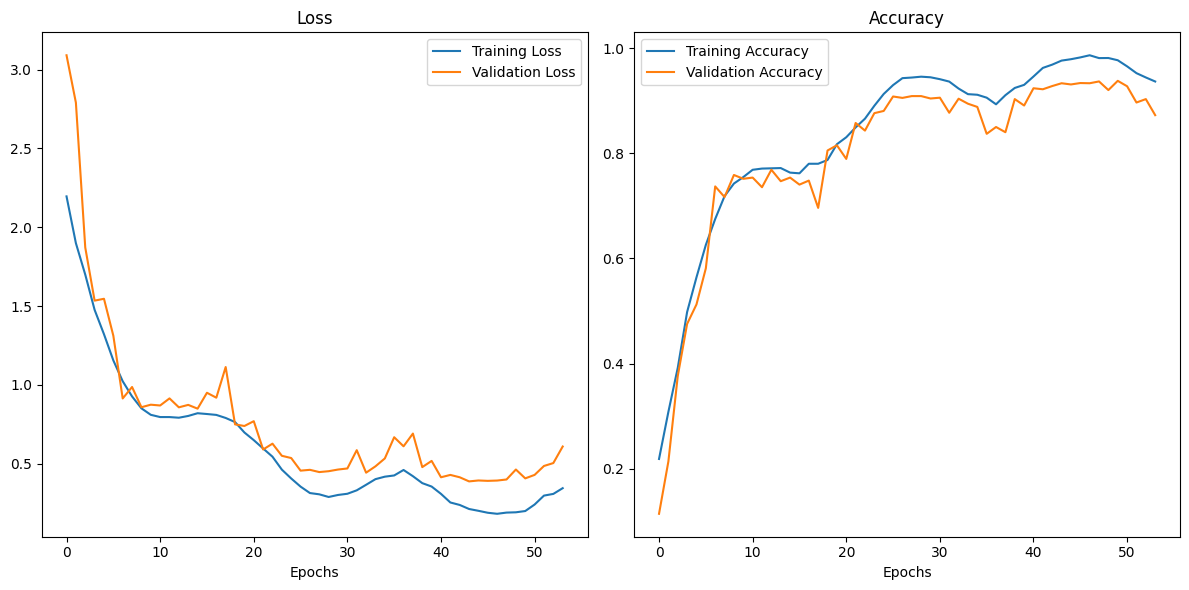

In [23]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title('Loss'); plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title('Accuracy'); plt.xlabel('Epochs')
plt.tight_layout(); plt.show()

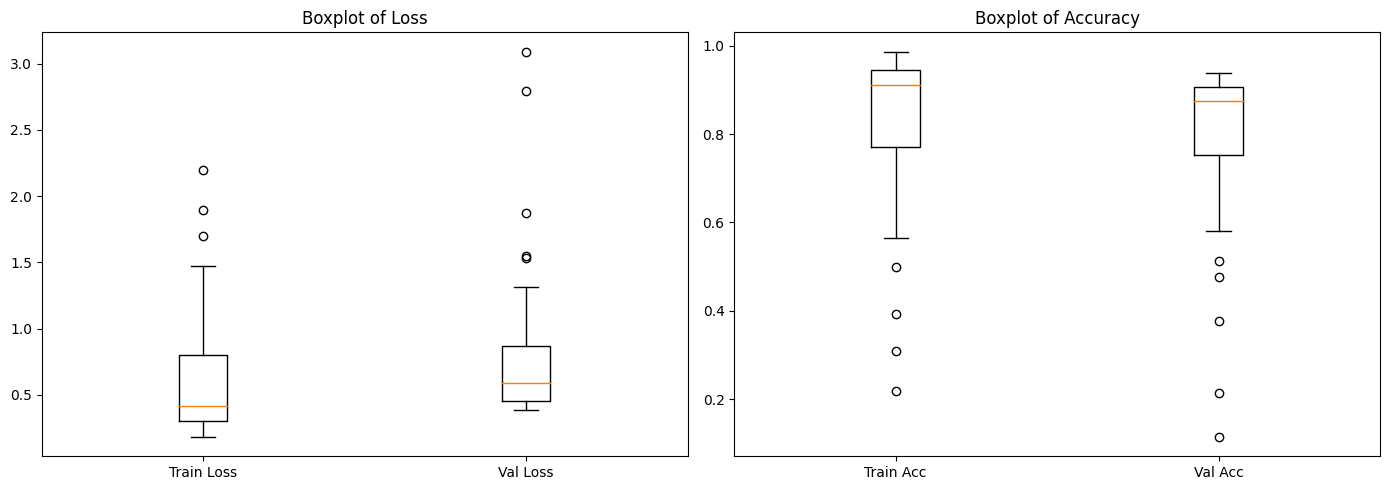

In [24]:
# More visualization
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].boxplot([history.history['loss'], history.history['val_loss']], labels=['Train Loss', 'Val Loss'])
axs[0].set_title('Boxplot of Loss')
axs[1].boxplot([history.history['accuracy'], history.history['val_accuracy']], labels=['Train Acc', 'Val Acc'])
axs[1].set_title('Boxplot of Accuracy')
plt.tight_layout(); plt.show()


82/82 ━━━━━━━━━━━━━━━━━━━━ 65s 775ms/step


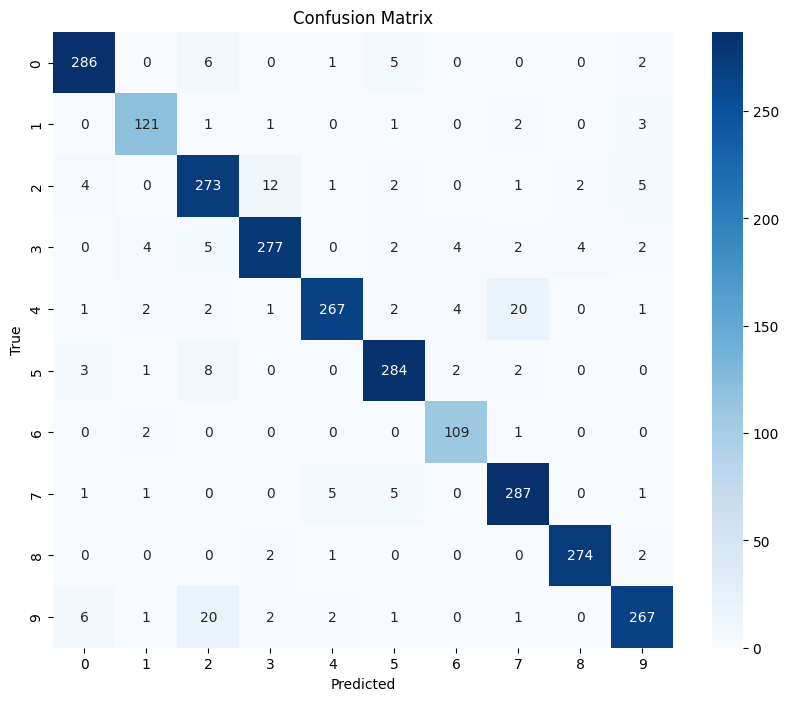

In [25]:

# Confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

In [26]:
model.save("/kaggle/working/Urbansound8K_CNN+LSTM_14042025.keras")

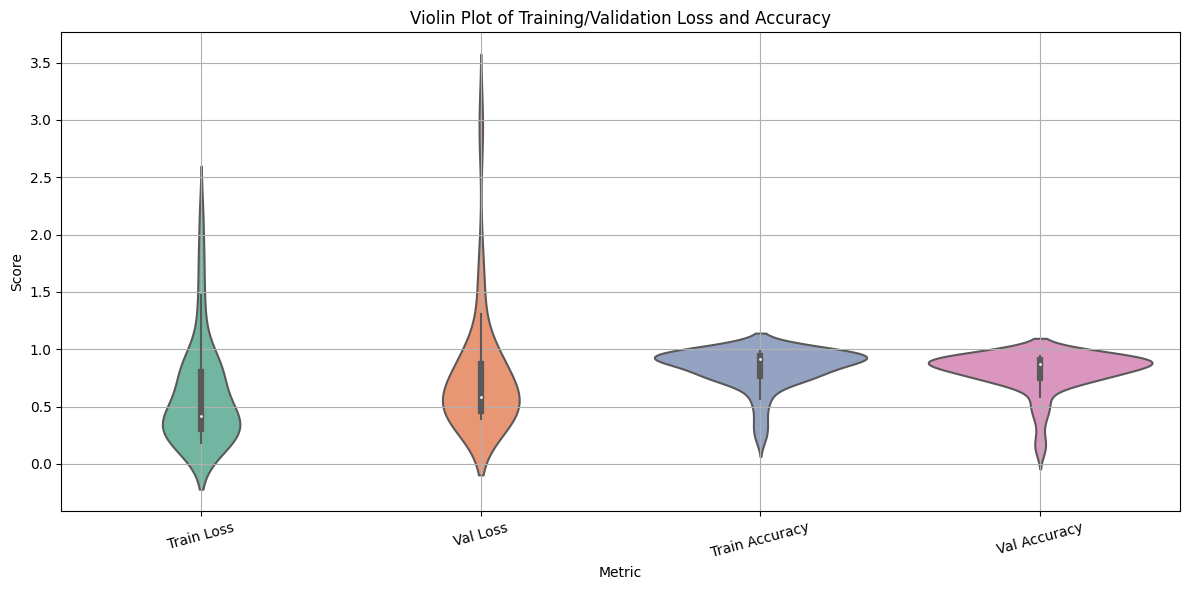

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert history to DataFrame
df = pd.DataFrame({
    'Train Loss': history.history['loss'],
    'Val Loss': history.history['val_loss'],
    'Train Accuracy': history.history['accuracy'],
    'Val Accuracy': history.history['val_accuracy']
})

# Melt the dataframe for easier plotting with seaborn
df_melted = df.melt(var_name='Metric', value_name='Value')

# Plot violin plots
plt.figure(figsize=(12, 6))
sns.violinplot(x='Metric', y='Value', data=df_melted, palette='Set2')
plt.title("Violin Plot of Training/Validation Loss and Accuracy")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()


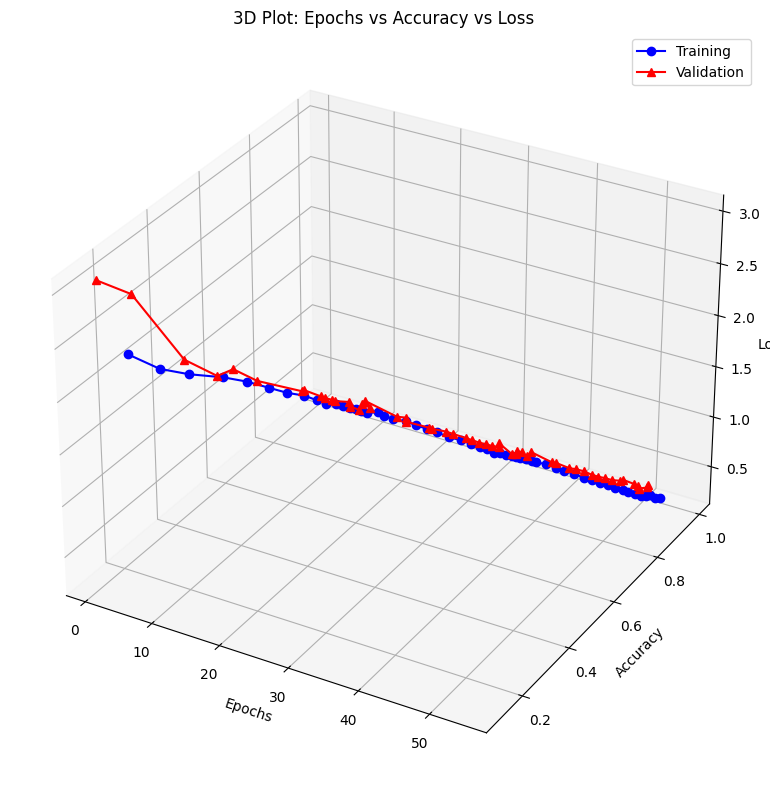

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
epochs = np.arange(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot training metrics
ax.plot(epochs, train_acc, train_loss, label='Training', color='blue', marker='o')

# Plot validation metrics
ax.plot(epochs, val_acc, val_loss, label='Validation', color='red', marker='^')

# Labels
ax.set_title('3D Plot: Epochs vs Accuracy vs Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_zlabel('Loss')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


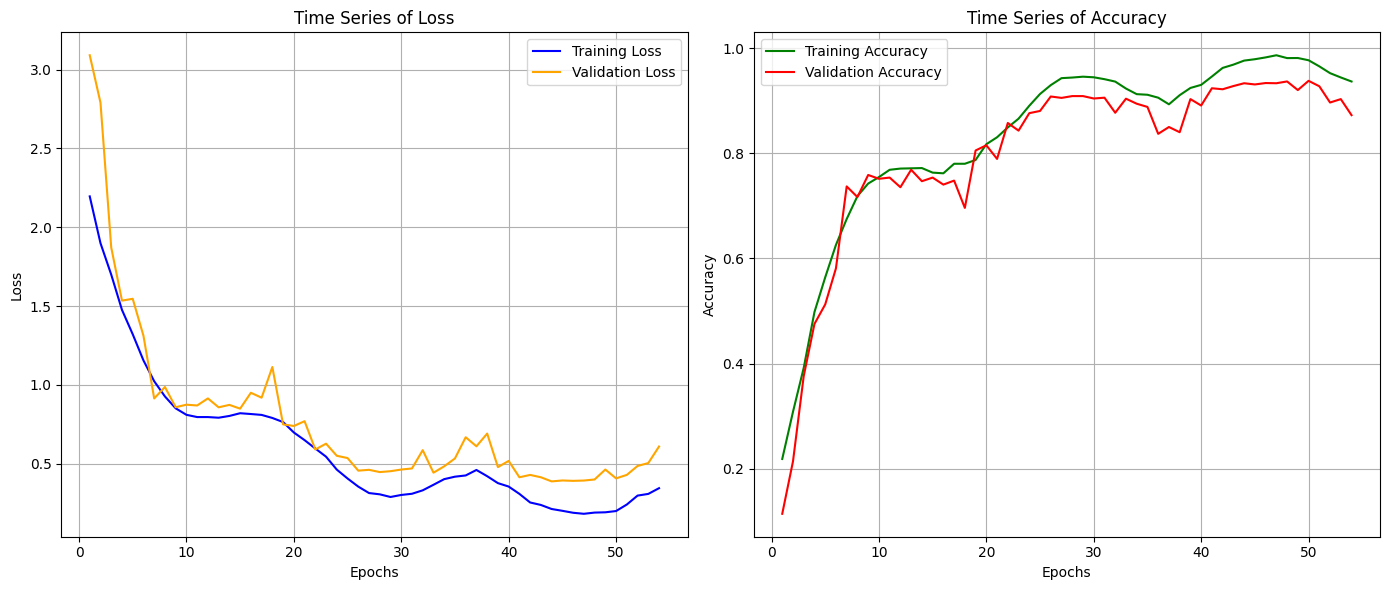

In [29]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(14, 6))

# 📉 Plot Loss over Time
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Time Series of Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 📈 Plot Accuracy over Time
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Time Series of Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


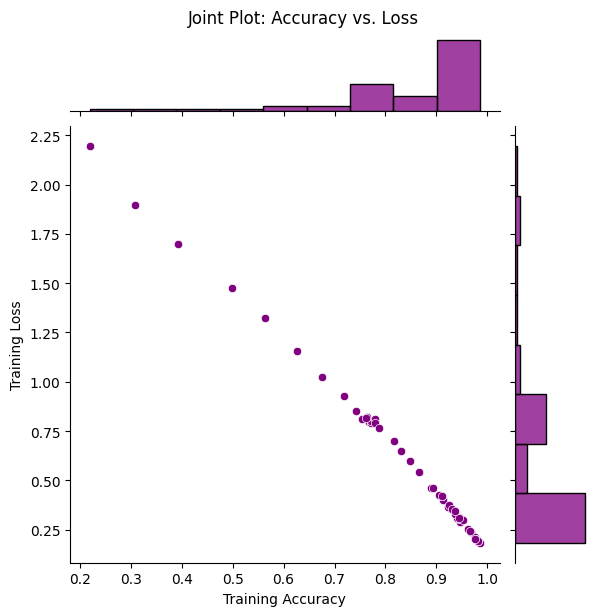

In [30]:
import seaborn as sns
import pandas as pd

# Prepare the data
metrics_df = pd.DataFrame({
    'Training Accuracy': history.history['accuracy'],
    'Training Loss': history.history['loss']
})

# Joint plot: Accuracy vs. Loss
sns.jointplot(data=metrics_df, x='Training Accuracy', y='Training Loss', kind='scatter', color='purple')
plt.suptitle("Joint Plot: Accuracy vs. Loss", y=1.02)
plt.show()


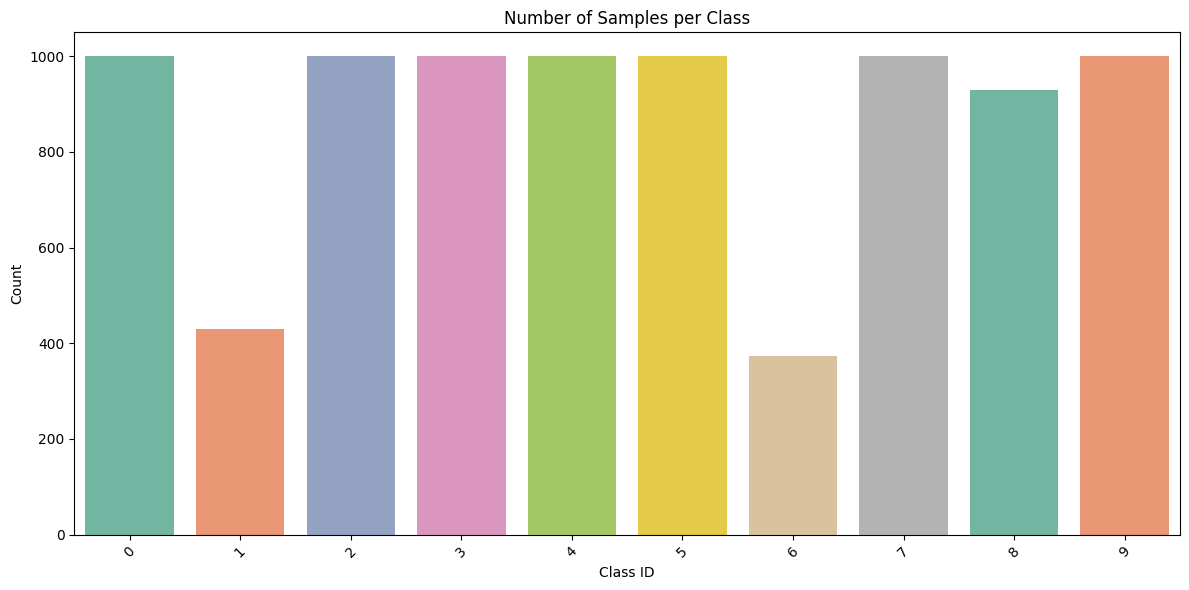

In [31]:
# Count per class
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(x='classID', data=metadata, palette='Set2')
plt.title("Number of Samples per Class")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


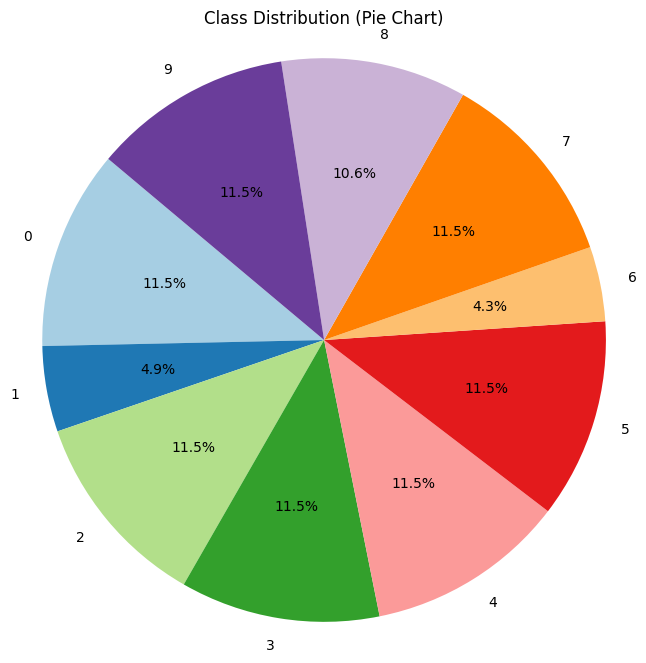

In [32]:
# Pie chart of class distribution
class_counts = metadata['classID'].value_counts().sort_index()
labels = [str(i) for i in class_counts.index]  # You can replace with actual class names if you want

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Class Distribution (Pie Chart)")
plt.axis('equal')
plt.show()
